# DQN on the CartPole problem

In this assignment you will implement the DQN algorithm to solve a classic control problem, the CartPole.

### The CartPole problem

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

<img src="https://drive.google.com/uc?export=download&id=1wiFksyB3-mcirfdZEvrT2DPD7SBEjye2" >

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).
The length of one episode is 200 time steps. Therefore the possible maximum score is 200.

The state is low dimensional and cosists of:
* position 
* velocity
* angle 
* angular velocity

Further details can be found on OpenAI gym's webpage: [Leader Board](https://github.com/openai/gym/wiki/CartPole-v0)

In [1]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import gym 
from gym.wrappers import Monitor
import numpy as np
import random
from enum import Enum
from skimage import transform as trf
from keras.models import Sequential # Keras: highlevel API above dnn libraries (tendorflow, cntr, theano)
from keras.layers import Dense, Convolution2D, Flatten,Activation
from keras.optimizers import Adam, SGD, RMSprop

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
class Optimizer(Enum): # Enum, Makes easier to try different optimizers
    ADAM = 1
    RMSPROP = 2
    SGD = 3

In [0]:
# The implementation of DQN.
class Dqn:
    
    def __init__(self, params):         
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay
        
        self.env = gym.make('CartPole-v0')
        self.env.reset()
        self.q_cont, self.q_frzn = self._init_models()
    
    # ------------------------------------------------------
    # functions for inicialization
    
    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):
        
        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')
            # ----- implement this -----
            # ----- create a sequential model -----
            q = Sequential()
            # ----- add a dense layer with input_shape 4 (4 frames will be stacked) -----
            q.add(Dense(strc[0][0],input_shape=(4,)))
            # use the strc for accessing the required parameters
            q.add(Activation(strc[0][1]))

            for i in range(1, len(strc)):
                # ----- add the remaining dense layers to the model
              q.add(Dense(strc[i][0]))
              q.add(Activation(strc[i][1]))

            optz = self._init_optimizer()
            # compile the model with an appropriate loss function
            q.compile(optimizer=optz, loss = 'mse')

            return q

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network

        q_cont.set_weights(q_frzn.get_weights())  # synchronization

        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        # ----- study and undertand this piece of code carefully -----
        exps = []
        obs, rw, done, _ = self.env.step(0)
        for _ in range(number):

            if done:
                obs = self.env.reset()

            action = self.env.action_space.sample()  # sampling random actions from the environment
            obs_next, rw, done, _ = self.env.step(action)  # taking the step and observe the results
            exps.append((obs, rw, action, done, obs_next))  # we append a new experience
            obs = obs_next

        self.append(exps)  # you will implement this function
    
    def close(self):
        self.env.close()

    def train_function(self):
        
        # initializing experience replay with random experiences
        self._init_buffer(self.batch_size)

        print("Initialization was finished.")
        print("Training was started.")

        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []
        
        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()
        obs, _, done, _ = self.env.step(0)

        while ep_id < self.max_episode:

            cntr += 1

            if done:
                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs = self.env.reset() # when an episode ends (done = True) the environment is reseted
            
            action = self.select_action_epsilon(state=obs,eps=eps)  # ---- select the next action with epsilon greedy -----

            obs_next, rw, done, _ = self.env.step(action)  # ----- take a new step with the environment -----
            rtn += rw
            
            if done:
                if rtn < 180:
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()
            
            # training
            if  cntr % self.train_freq == 0:
                # ----- sample experiences from the replay then train q_cont with them
                x,y = self.sample(self.batch_size)
                self.q_cont.fit(x,y,epochs = self.epoch,batch_size = self.batch_size, verbose=0)

            # synchronizing the frozen network
            if cntr % self.C == 0:
                self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                print('EValuation at episode: ' + str(ep_id) + ' -> ' +  str(r))
                eval_permitted = False
                if r >= 185:
                    break
            
            # Decrasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False):
        
        orig_env = self.env
        if video:
            self.env = Monitor(orig_env, 'videos/cartpole', force=True)

        obs = self.env.reset()
        done = False
        rtn = 0
        ep_id = 0
        rtns = []

        while ep_id < 50:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs = self.env.reset()

            action = self.select_action_epsilon(obs, 0.01)
            obs, rw, done, _ = self.env.step(action)
            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        # experiences - list of experiences
        # ----- implement this -----
        
        # ----- check if appending the new set of experiences to the buffer has enough space -----
        if len(self.buffer)+len(experiences) > self.buffer_size:
            # ----- if not, delete as many experiences as required -----
            del self.buffer[0:len(experiences)]
        self.buffer += experiences  # finally we append the new experiences to the buffer

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs = np.stack([x[0] for x in exps], axis=0) # numpy array is used by keras, for creating a batch observations should be stacked
        rws = np.stack([x[1] for x in exps], axis=0) # ----- do similar stacking for the rewards -----
        acts = np.stack([x[2] for x in exps], axis=0) # ----- implement this too -----
        dones = np.stack([x[3] for x in exps], axis=0) # ----- implement this too -----
        next_obs = np.stack([x[4] for x in exps], axis=0) # ----- implement this too -----

        q_vals = self.q_cont.predict(obs,batch_size=number) # ----- predict (forward execute) with q_cont on obs -----   # q_vals size should be: (batch_size, 2)
        fzn_q_vals = self.q_frzn.predict(next_obs,batch_size=number) # ----- predict with q_frzn on next_obs -----
        
        # The action function is represented by a network.
        # The input of this network is the state, 
        # the output is the set of action-values
        # corresponding to the actions.
        # So the number of outputs is equal with the nunmber of actions.
        # In training we sample one transition at a time, therefore we have loss
        # for only one output (action) at a time.
        # But for training, we have to provide information for all of the outputs.
        # How can we solve this?
        sub_values = [] # ----- calculate this according to the one-step return for Q-learning -----
        for rewards, done, frzn_q_val in zip(rws, dones,fzn_q_vals):
          if done:
            sub_values.append(rewards)
          else:
            sub_values.append(rewards + self.gamma * max(frzn_q_val))
        q_vals[list(range(number)), acts] = sub_values  # this will be the target during training

        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)

        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1))

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

EValuation at episode: 10 -> 9.72
Episode Id: 10 Return during training: 11.0
EValuation at episode: 20 -> 11.78
Episode Id: 20 Return during training: 13.0
EValuation at episode: 30 -> 10.88
Episode Id: 30 Return during training: 11.0
EValuation at episode: 40 -> 11.94
Episode Id: 40 Return during training: 14.0
EValuation at episode: 50 -> 12.14
Episode Id: 50 Return during training: 11.0
EValuation at episode: 60 -> 12.04
Episode Id: 60 Return during training: 12.0
EValuation at episode: 70 -> 12.26
Episode Id: 70 Return during training: 13.0
EValuation at episode: 80 -> 16.42
Episode Id: 80 Return during training: 13.0
EValuation at episode: 90 -> 19.74
Episode Id: 90 Return during training: 14.0
EValuation at episode: 100 -> 42.72
Episode Id: 100 Return during training: 44.0
EValuation at episode: 110 -> 62.24
Episode Id: 110 Return during training: 

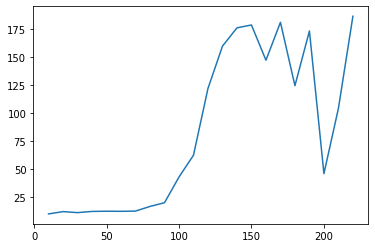

In [5]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

In [0]:
class Parameters1:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 300        # 500
        self.eps = 0.1           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 80              # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
EValuation at episode: 10 -> 9.6
Episode Id: 10 Return during training: 11.0
EValuation at episode: 20 -> 9.3
Episode Id: 20 Return during training: 9.0
EValuation at episode: 30 -> 9.64
Episode Id: 30 Return during training: 10.0
EValuation at episode: 40 -> 9.66
Episode Id: 40 Return during training: 10.0
EValuation at episode: 50 -> 9.42
Episode Id: 50 Return during training: 10.0
EValuation at episode: 60 -> 9.46
Episode Id: 60 Return during training: 9.0
EValuation at episode: 70 -> 9.52
Episode Id: 70 Return during training: 10.0
EValuation at episode: 80 -> 9.34
Episode Id: 80 Return during training: 10.0
EValuation at episode: 90 -> 9.62
Episode Id: 90 Return during training: 8.0
EValuation at episode: 100 -> 9.22
Episode Id: 100 Return during training: 11.0
EValuation at episode: 110 -> 9.58
Episode Id: 110 Return during training: 14.0
EValuation at episode: 120 -> 9.5
Episode Id: 120 Return during training: 9.0
EValuation at 

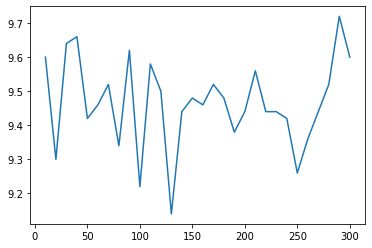

In [49]:
# Running the training and evaluation
pms = Parameters1()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

### Question:

* Does it converge all the time?

Answer:

No, with the default parameters does not converge all the time, due to the stochastic nature of the algorithm. The DQN cannot learn the stochastic policies.Secondly, the synchronization frequency of the frozen layer impacts the learning. In the default parameter setting, the frozen layer synchronization frequency is 100, which means that the synchronization happens once in 100, but it is to be kept in mind that this 100 datapoints would differ every time the training happens, so everytime the DQN is trained on a different bunch of those 100 data points and synchronized. Thirdly, the high epsilon value and small annealing value makes its longer to go from exploration to exploitation.

* What happens if you change the default parameters?

Answer:

Ways to make the convergence better or improve the algorithm performance:

1. Change Epsilon(from 0.5 to 0.1): Once the epsilon value is lowered, the network allows to go from exploration to exploitation faster.
2. Reduce synchronization frequency by 20%(from 100 to 80): The reduction of the synchronization frequency with less radical dataset everytime, which makes the converging of the network easier.
3. Reduce the maximum number of episodes(500 to 300): The reduction of the maximum number of episodes improves the convergence rate of the network too.

Hence, with all the above parameter combinations the network starts to converge which in comparison to the default parameters is better. But, caution must be taken while altering the parameters as the convergence could go worse even with a minor miscalculation of the parameter settings.
